# Classification of Fashion MNIST Dataset

In [1]:
# import reqired libraries
import os
import sys
import numpy as np
import struct

In [2]:
# Fetch data
LOCAL_PATH = "datasets/fashion"

In [3]:
def load_data(path=LOCAL_PATH):
    train_img = os.path.join(path, 'train-images-idx3-ubyte')
    train_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    test_img = os.path.join(path, 't10k-images-idx3-ubyte')
    test_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    
    # Load as numpy arrays
    with open(train_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        y_train = np.fromfile(flbl, dtype=np.int8)
        
    with open(test_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        y_test = np.fromfile(flbl, dtype=np.int8)
        
    with open(train_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        X_train = np.fromfile(fimg, dtype=np.int8).reshape(len(y_train), rows, cols)
        
    with open(test_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        X_test = np.fromfile(fimg, dtype=np.int8).reshape(len(y_test), rows, cols)
        
    return X_train, y_train, X_test, y_test

In [4]:
X_train, y_train, X_test, y_test = load_data()

In [5]:
print("Train data...")
print("num_samples: ",X_train.shape[0])
print("Image size: ", (X_train.shape[1], X_train.shape[2]))
print("Teast data...")
print("num_samples: ",X_test.shape[0])
print("Image size: ", (X_test.shape[1], X_test.shape[2]))

Train data...
num_samples:  60000
Image size:  (28, 28)
Teast data...
num_samples:  10000
Image size:  (28, 28)


In [6]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker",
         "Bag", "Ankle Boot"]

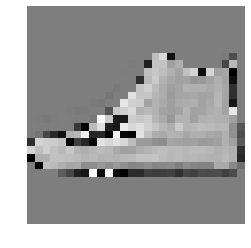

label:  Ankle Boot


In [7]:
# Lets visualize..
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_sample_img = X_train[42000]
plt.imshow(some_sample_img, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
print("label: ", labels[y_train[42000]])

In [8]:
# Let's reshape the image as one long vector
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
print("Train_img:", X_train.shape)
print("Train_lbl:", y_train.shape)
print("Test_img:", X_test.shape)
print("Test_lbl:", y_test.shape)

Train_img: (60000, 784)
Train_lbl: (60000,)
Test_img: (10000, 784)
Test_lbl: (10000,)


In [9]:
# Shuffle the training data
np.random.seed(42) 
shuffle_idx = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[shuffle_idx], y_train[shuffle_idx]

## Binary Classifier
Let's build a binary classifier to identify bags

In [10]:
y_train_bag = (y_train==8) #has to be in this form. y_train[y_train==8] does not work!!
y_test_bag = (y_test==8)

# Using Stochastic Gradient Descent Classifier:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, tol=1e-3)
sgd_clf.fit(X_train, y_train_bag)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
some_sample_image = X_train[4]
sgd_clf.predict(X_train[4:5])

array([ True])

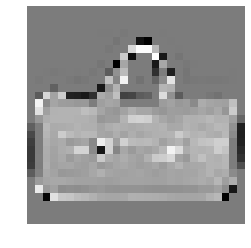

In [12]:
# plot to check
some_sample_image = X_train[4].reshape(28,28)
plt.imshow(some_sample_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

### Let's use Cross validation to check how well this classifier performs.
Before that, let's try to use stratified sampling to ensure that the bag class is evenly distributed amog the k-folds

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_bag):
    clone_clf = clone(sgd_clf) #Clone the classifier across diff folds
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_bag[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_bag[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))
    

0.9241
0.93025
0.91845


### Comments:
Binary classifier for bag gives ~92% accuracy on cross-val of 3 splits. Let's see what happens if we always predict that there is no bag -> to get a sense of whether using accuracy is a good metric

In [14]:
from sklearn.base import BaseEstimator
class NoBagClassifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X)), dtype=bool)

In [15]:
no_bag_clf = NoBagClassifier()
from sklearn.model_selection import cross_val_score
cross_val_score(no_bag_clf, X_train, y_train_bag, cv=3, scoring="accuracy")

array([0.89995, 0.8996 , 0.90045])

### Comments: 
We get ~90% accuracy on cross-val for always predicting that its not a bag. Hence we cannot use accuracy as a metric as the dataset is skewed. Only abt 10% of data contains bags. Let's take a look at the confusion matrix

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_bag, cv=5)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_bag, y_train_predict)

array([[52548,  1452],
       [ 3022,  2978]])

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("Precision:",precision_score(y_train_bag, y_train_predict))
print("Recall:",recall_score(y_train_bag, y_train_predict))
print("F1:", f1_score(y_train_bag, y_train_predict))

Precision: 0.672234762979684
Recall: 0.49633333333333335
F1: 0.5710450623202301


Bag Detector is only correct 67% of the time & only detects 50% of the bags!!

In [19]:
# Plot precision-recall for different thresholds
'''Scikit-Learn does not let you set the threshold directly, but it does give you access to
the decision scores that it uses to make predictions. Instead of calling the classifier’s
predict() method, you can call its decision_function()'''
y_score = sgd_clf.decision_function(X_train[3:4])
print(y_score)

[-7583.72603354]


In [20]:
thresh = 0
y_pred = (y_score>thresh)
print(y_pred)

[False]


In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_bag, cv=3, method="decision_function")

In [22]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_bag, y_scores)

In [23]:
def plot_precision_recall_curve(precisons, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="recall")
    plt.xlabel("threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])

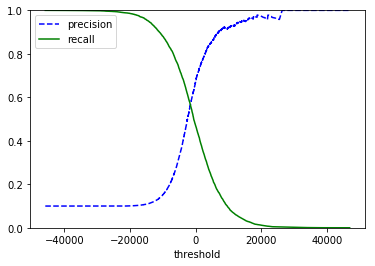

In [24]:
plot_precision_recall_curve(precisions, recalls, thresholds)
plt.show()

Why Precision curve is bumpier than recall? The reason is that precision may sometimes go
down when you raise the threshold

In [25]:
# Plot Precision v/s Recall (PR) curve
def plot_PR(precisions, recalls):
    plt.plot(recalls, precisions)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")

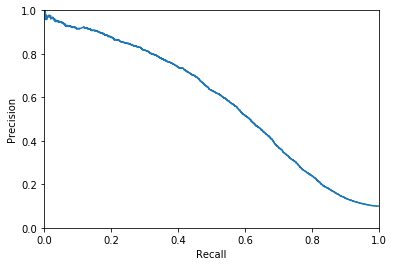

In [26]:
plot_PR(precisions, recalls)

In [29]:
# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_bag, y_scores)

In [30]:
def plot_roc(tpr, fpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('F.P. rate')
    plt.ylabel('T.P. rate')
    

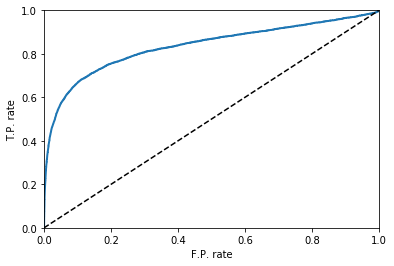

In [31]:
plot_roc(tpr, fpr)
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_bag, y_scores)

0.834665700617284

### Note: 
Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives, and the ROC curve otherwise.

### Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_bag, cv=3, method="predict_proba")

/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [34]:
y_probs_forest

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [35]:
y_scores_forest = y_probs_forest[:,1]
fpr, tpr, thresholds = roc_curve(y_train_bag, y_scores_forest)

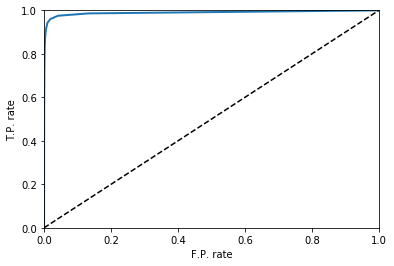

In [36]:
plot_roc(tpr, fpr)

In [37]:
roc_auc_score(y_train_bag, y_scores_forest)

0.9895971141975308

In [39]:
y_forest_predict = cross_val_predict(forest_clf, X_train, y_train_bag, cv=3)

/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [40]:
print("Precision:",precision_score(y_train_bag, y_forest_predict))
print("Recall:",recall_score(y_train_bag, y_forest_predict))
print("F1:", f1_score(y_train_bag, y_forest_predict))

Precision: 0.9688249400479616
Recall: 0.8753333333333333
F1: 0.9197093074161632


## MultiClass Classification

In [41]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [47]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

### Note:
cross_val_score -> gives the accuracy on each cross_val set
cross_val_predict -> gives predictions on each cross-val set

In [51]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [52]:
y_pred_sgd = cross_val_score(sgd_clf, X_train, y_train, cv=3)

In [53]:
y_pred_sgd

array([0.5176 , 0.54275, 0.5302 ])

In [54]:
cross_val_score(forest_clf, X_train, y_train, cv=3)

/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0.81455, 0.8118 , 0.8071 ])

In [56]:
# Apply normalization before training
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
y_pred_sgd = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3)
y_pred_forest = cross_val_score(forest_clf, X_train_scaled, y_train, cv=3)

/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/manisha/an

In [57]:
y_pred_sgd

array([0.53915, 0.5439 , 0.5527 ])

In [58]:
y_pred_forest

array([0.8145 , 0.81165, 0.8068 ])

### Note:
Not much change after scaling as well!

/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/home/manisha/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


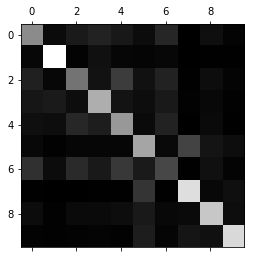

In [60]:
# Visualize Confusion Matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

### One v/s One Classifier for SVM

In [64]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
svm_clf = SVC(gamma='auto')
n_classes = len(labels)
ovo_clf = OneVsOneClassifier(svm_clf)
ovo_clf .fit(X_train_scaled, y_train)


OneVsOneClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=None)

In [65]:
ovo_clf.predict(X_train_scaled[5:6])
# cross_val_score(ovo_clf, X_train_scaled, y_train, cv=3)

array([4], dtype=int8)

In [66]:
y_train[5]

4

In [ ]:
y_pred_scores = cross_val_score(ovo_clf, X_train_scaled, y_train, cv=3)